## Análisis de temas

En este código se toma un conjunto de noticias, se exstraen los temas principales y los candidatos mencionados en cada nota en partidos importantes. 


In [1]:
import pandas as pd

df = pd.read_csv('../data/raw/noticias_limpias.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   enlace              204 non-null    object
 1   seccion             204 non-null    object
 2   pagina              204 non-null    int64 
 3   fecha_publicacion   204 non-null    object
 4   titulo              204 non-null    object
 5   descripcion         204 non-null    object
 6   vistas              204 non-null    object
 7   categorias          204 non-null    object
 8   titulo_limpio       204 non-null    object
 9   descripcion_limpia  204 non-null    object
 10  titulo_tokens       204 non-null    object
 11  descripcion_tokens  204 non-null    object
 12  vistas_num          204 non-null    int64 
 13  fecha_normalizada   204 non-null    object
 14  categorias_limpias  204 non-null    object
 15  dudoso              204 non-null    bool  
dtypes: bool(1), int64(2), obje

In [18]:
import pandas as pd
import re

# --- Diccionario completo de partidos ---
partidos_todos = {
    "Frente Justicialista Creer Entre Ríos (PJ/FdT)": [
        "frente justicialista creer entre ríos", "frente creer", "creer", "pj", "justicialista", "peronismo", "bordet", "frente de todos", "fdt"
    ],
    "Juntos por el Cambio / Juntos por Entre Ríos (JxC)": [
        "juntos por el cambio", "juntos por entre ríos", "jxc", "cambiemos", "u.c.r.", "ucr", "radicales", "pro", "propuesta republicana", "macri", "larreta", "frigerio", "gen", "movimiento social entrerriano", "mse"
    ],
    # Partidos menores:
    "Confederación Vecinalista Entre Ríos": [
        "confederación vecinalista", "vecinalista", "vecinales"
    ],
    "Nueva Izquierda": [
        "nueva izquierda", "izquierda", "mst", "partido de los trabajadores", "socialismo de izquierda"
    ],
    "Partido Socialista": [
        "partido socialista", "socialista", "ps"
    ],
    "Partido Fe": [
        "partido fe", "fe"
    ],
    "Partido Conservador Popular": [
        "partido conservador popular", "conservador popular"
    ],
    "Movimiento Social Entrerriano": [
        "movimiento social entrerriano", "mse"
    ]
}

principales = [
    "Frente Justicialista Creer Entre Ríos (PJ/FdT)",
    "Juntos por el Cambio / Juntos por Entre Ríos (JxC)"
]

# --- Función extendida ---
def detectar_partidos_mencionados(row):
    texto = f"{row['titulo_limpio']} {row['descripcion_limpia']}".lower()
    partidos_detectados = set()
    otros_detectados = False

    for partido, variantes in partidos_todos.items():
        for variante in variantes:
            if re.search(r'\b' + re.escape(variante) + r'\b', texto):
                if partido in principales:
                    partidos_detectados.add(partido)
                else:
                    otros_detectados = True
                break

    # Agregar "Otros partidos" si se detectó alguno menor
    if otros_detectados:
        partidos_detectados.add("Otros partidos")

    # Si no se detectó ningún partido ni menor
    if not partidos_detectados:
        return ["Sin partidos"]

    return list(partidos_detectados)

df['partidos_mencionados'] = df.apply(detectar_partidos_mencionados, axis=1)


In [20]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import spacy

# --- Generar embeddings y evaluar clusters ---

# Cargar modelo spaCy para español
nlp = spacy.load("es_core_news_sm")

def limpiar_y_lemmatizar(texto):
    doc = nlp(texto.lower())
    return " ".join([
        token.lemma_ for token in doc
        if token.is_alpha and not token.is_stop and len(token) > 2
    ])

# Aplicar al texto completo
df['texto_limpio'] = df['texto_completo'].apply(limpiar_y_lemmatizar)

# Modelo multilingüe (compacto y rápido)
model = SentenceTransformer('all-MiniLM-L6-v2')  # anda bien en español
embeddings = model.encode(df['texto_limpio'].tolist(), show_progress_bar=True)


Batches: 100%|██████████| 7/7 [00:19<00:00,  2.72s/it]


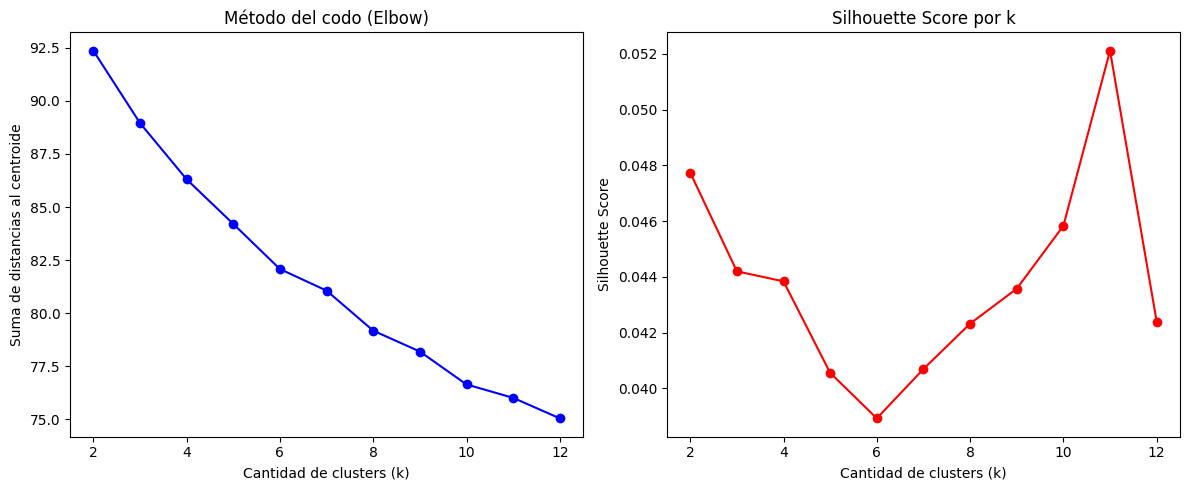

In [21]:
# --- Evaluar cantidad óptima de clusters ---
suma_cuadrados = []
silhouette_scores = []
K = range(2, 13)  # Probá de 2 a 12 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = kmeans.fit_predict(embeddings)
    suma_cuadrados.append(kmeans.inertia_)  # Inertia = suma de distancias al centroide
    silhouette_scores.append(silhouette_score(embeddings, labels))

# Gráfico de codo (elbow)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, suma_cuadrados, 'bo-')
plt.xlabel('Cantidad de clusters (k)')
plt.ylabel('Suma de distancias al centroide')
plt.title('Método del codo (Elbow)')

# Gráfico de Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'ro-')
plt.xlabel('Cantidad de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score por k')
plt.tight_layout()
plt.show()


In [22]:
# Elegir cantidad de clusters (temas)
n_temas = 6  # Cambiá este número según la variedad de tu corpus

kmeans = KMeans(n_clusters=n_temas, random_state=42, n_init=20)
labels = kmeans.fit_predict(embeddings)
df['tema_cluster'] = labels

# --- 3. (Opcional) Revisar y renombrar los temas manualmente ---

# Ver palabras frecuentes por cluster para ponerles nombre a mano:
for i in range(n_temas):
    textos = df[df['tema_cluster'] == i]['texto_completo']
    print(f"Tema {i}:")
    # Podés ajustar o usar Counter para mostrar las palabras más repetidas.
    print(" ".join(textos).split()[:50])
    print("\n---\n")

# Si querés, después de ver el print, podés armar un dict tipo:
# nombres_temas = {0: "Economía", 1: "Política", ...}
# df['tema_nombre'] = df['tema_cluster'].map(nombres_temas)

# --- 4. Guardar el resultado final ---
df.to_csv("noticias_con_partidos_y_temas.csv", index=False)

Tema 0:
['el', 'hermano', 'de', 'manuel', 'adorni', 'fue', 'designado', 'presidente', 'del', 'instituto', 'de', 'retiros', 'y', 'pensiones', 'militares.', 'la', 'designacion', 'de', 'francisco', 'jorge', 'adorni', 'se', 'realizo', 'tras', 'la', 'renuncia', 'de', 'betina', 'betsabe', 'surballe', 'el', 'ministro', 'de', 'defensa', 'luis', 'petri', 'designo', 'al', 'contador', 'publico', 'francisco', 'jorge', 'adorni', 'como', 'nuevo', 'presidente', 'del', 'instituto', 'de', 'ayuda']

---

Tema 1:
['creditos', 'de', 'hasta', 'millones', 'de', 'pesos', 'para', 'comprar', 'un', 'auto', 'montos', 'cuotas', 'y', 'mas', 'detalles.', 'el', 'gobierno', 'nacional', 'lanzo', 'una', 'linea', 'de', 'prestamos', 'a', 'traves', 'del', 'banco', 'nacion', 'para', 'adquirir', 'autos', 'los', 'creditos', 'son', 'personales', 'no', 'prendarios', 'el', 'gobierno', 'nacional', 'lanzo', 'una', 'linea', 'de', 'prestamos', 'a', 'traves', 'del', 'banco', 'nacion']

---

Tema 2:
['a', 'anos', 'del', 'atentado', '

In [23]:
# Cantidad de noticias por tema
tema_counts = df['tema_cluster'].value_counts().sort_index()
print(tema_counts)


tema_cluster
0    18
1    55
2    37
3    39
4    25
5    30
Name: count, dtype: int64


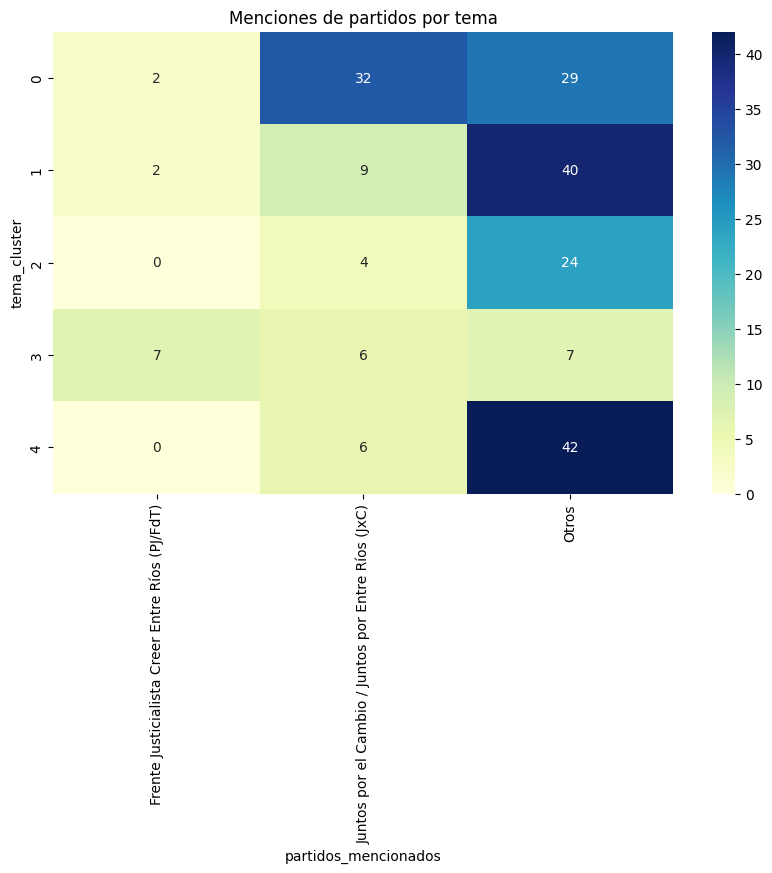

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(tabla_partido_tema, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Menciones de partidos por tema')
plt.show()


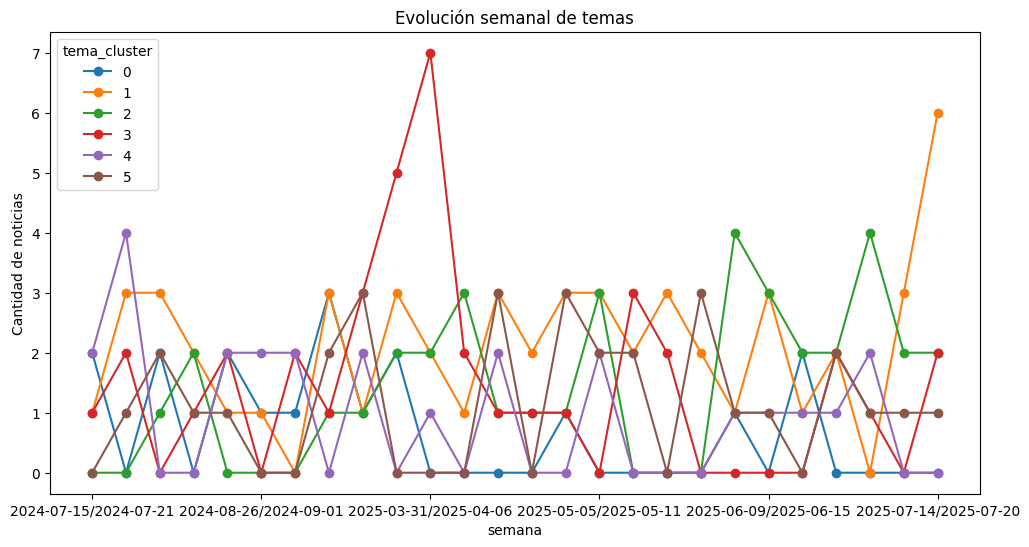

In [27]:
tabla_temporal.plot(figsize=(12,6), marker='o')
plt.ylabel('Cantidad de noticias')
plt.title('Evolución semanal de temas')
plt.show()


In [29]:
import networkx as nx
from collections import Counter
from itertools import combinations
import matplotlib.pyplot as plt

# Si tenés stopwords propias, podés agregarlas así:
stopwords = set([
    "de", "la", "el", "y", "en", "a", "los", "del", "con", "por", "para", 
    "es", "se", "que", "una", "un", "al", "las", "su", "como", "más", "o"
])

def grafo_coocurrencia_por_tema(df, tema_id, top_n=30, window_size=2, min_cooc=2):
    # Filtrar textos del tema
    textos = df[df['tema_cluster'] == tema_id]['texto_completo']
    
    # Tokenizar y filtrar stopwords
    tokens = []
    for texto in textos:
        tks = [t for t in texto.lower().split() if t not in stopwords and len(t) > 2]
        tokens.append(tks)
    
    # Contar coocurrencias dentro de una ventana deslizante (window_size)
    coocurrencias = Counter()
    for tks in tokens:
        for i in range(len(tks) - window_size + 1):
            
            window = tks[i:i+window_size]
            for w1, w2 in combinations(window, 2):
                if w1 != w2:
                    par = tuple(sorted([w1, w2]))
                    coocurrencias[par] += 1

    # Filtrar las más frecuentes
    coocurrencias = {k: v for k, v in coocurrencias.items() if v >= min_cooc}
    top_pairs = dict(Counter(coocurrencias).most_common(top_n))

    # Crear grafo
    G = nx.Graph()
    for (w1, w2), peso in top_pairs.items():
        G.add_edge(w1, w2, weight=peso)
    
    return G

def plot_grafo_coocurrencia(G, tema_id):
    plt.figure(figsize=(12,8))
    pos = nx.spring_layout(G, k=0.6)
    weights = [G[u][v]['weight'] for u,v in G.edges()]
    nx.draw_networkx_nodes(G, pos, node_size=800, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, width=[w*0.8 for w in weights], alpha=0.6)
    nx.draw_networkx_labels(G, pos, font_size=13)
    plt.title(f"Grafo de coocurrencia de palabras - Tema {tema_id}")
    plt.axis('off')
    plt.show()


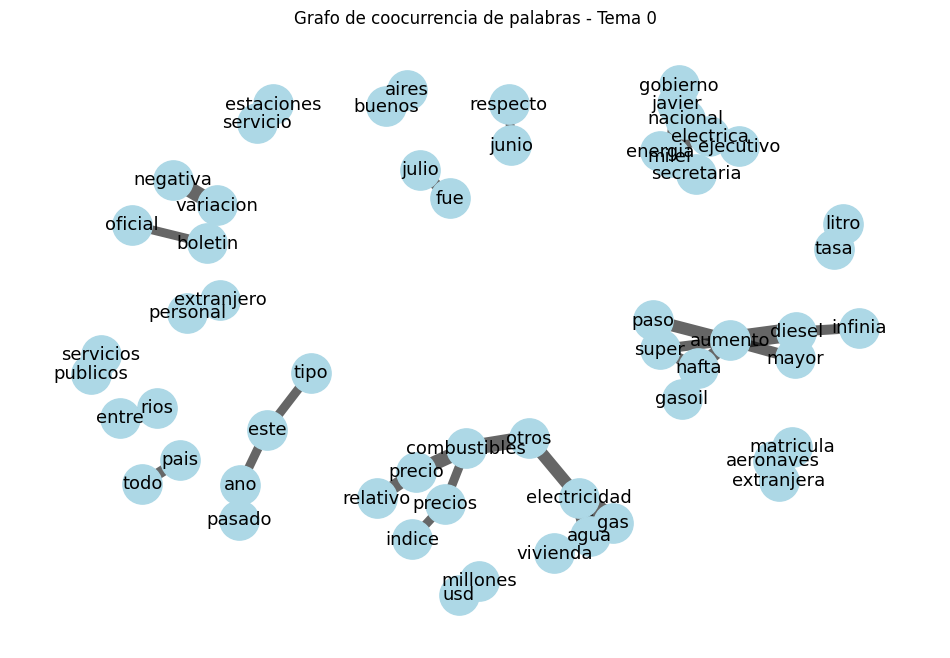

In [30]:
tema_id = 0  # Cambiá el número de tema/cluster que quieras analizar
G = grafo_coocurrencia_por_tema(df, tema_id, top_n=40, window_size=3, min_cooc=2)
plot_grafo_coocurrencia(G, tema_id)
